Source: [part 3](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)

In [2]:
import os
from IPython.display import Image 

pth = os.getcwd()
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from: 

- [Paper - Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.



## Introduction

As a reminder, here is the general encoder-decoder model:

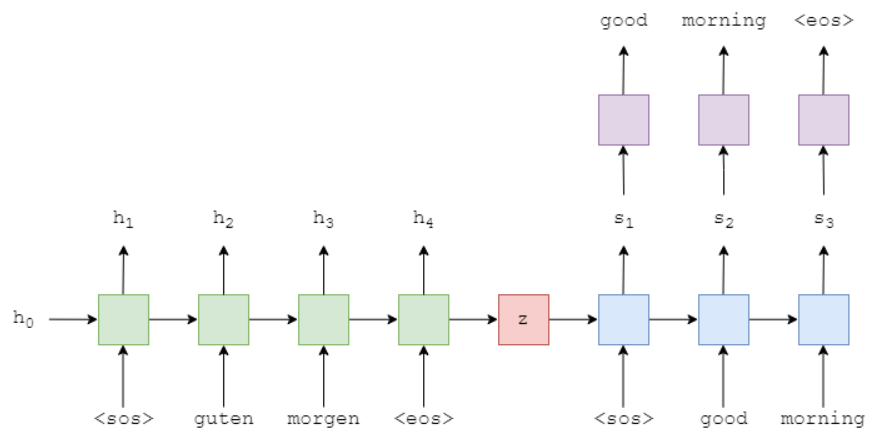

In [4]:
Image(filename = pth + "/images/rnn_translation.png")

In the previous model (sequence to sequence GRU), our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and input word, $y_t$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.


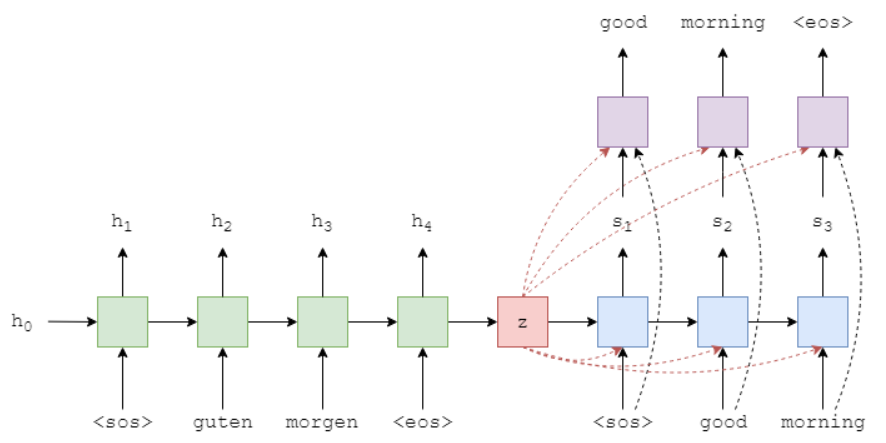

In [6]:
Image(filename = pth + "/images/seq2seqGRU.png")

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. \
 \
    Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. \
 \
    $$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.tensor as Tensor

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

In [20]:
# Set random seeds for reproducibility

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 1. Create the Tokenizers

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"].

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

In [4]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
spacyDE = spacy.load('de')
spacyEN = spacy.load('en')

### 2. Create the Tokenizer Functions

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [21]:
# Creating the tokenizer functions
# NOTE: not reversing source (German) anymore.

def tokenizeGerman(germanText: str):
    """
    Tokenizes German text from a string into a list of strings (as tokens)
    :param germanText: 
    :return: 
    """
    return [tok.text for tok in spacyDE.tokenizer(germanText)]

def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

We set the tokenize argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The `Field` also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

[To read more about Field's arguments](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)


In [22]:
# German = source language, English = target language

# tokenize:  The function used to tokenize strings using this field into
#             sequential examples.
# init_token: A token that will be prepended to every example using this
#             field, or None for no initial token. Default: None.
# eos_token: A token that will be appended to every example using this
#             field, or None for no end-of-sentence token. Default: None.
# lower: Whether to lowercase the text in this field. Default: False.
SRC = Field(tokenize = tokenizeGerman,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

### 3. Download the Data

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset).
This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence.

In [23]:
# `exts` : specifies which languages to use as the source and target
# (source goes first) 
# `fields`: specifies which field to use for the source and target.

# NOTE: after this, the data is stored in 
# a folder under NLPSTUDY called '.data'
trainData, validationData, testData = Multi30k.splits(exts = ('.de', '.en'),
                                                      fields = (SRC, TRG))

In [24]:
# Print out examples to verify the source (German) is not reversed ...

# Double-checking we have the right number of examples: 
print(f"Number of training examples: {len(trainData.examples)}")
print(f"Number of validation examples: {len(validationData.examples)}")
print(f"Number of testing examples: {len(testData.examples)}")

print("\n")

# Printing out an example to make sure the source sentence is
# not reversed (if you know German); the target (english) is in proper order, though. 
print(trainData.examples[0])
print(vars(trainData.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### 4. Building the vocabulary

Next, we build the *vocabulary* for the source and target languages.

The vocabulary is used to associate each unique token (word) with an index (an integer), similar to the way a dictionary works.

This is used to build a one-hot encoding for each token (a vector of all zeros except for the position represented by the index, which is 1).

The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

WARNING: It is important to note that your vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into your model, giving you artifically inflated validation/test scores.

In [25]:
SRC.build_vocab(trainData, min_freq=2)
TRG.build_vocab(trainData, min_freq=2)

In [27]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### 5. (Final) Create the Iterators

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us!

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [29]:
# Creating the training iterator

BATCH_SIZE = 128

trainIterator, validationIterator, testIterator = BucketIterator.splits(
    (trainData, validationData, testData),
    batch_size = BATCH_SIZE,
    device = device)

## Building the Seq2Seq Model (GRU)

**Overview:** We use a  bidirectional GRU `Encoder` and non-bidirectional GRU `Decoder`.

#### [GRU Formulation](https://hyp.is/FV-GHhAsEeqa9B_lR5PiZg/pytorch.org/docs/stable/nn.html)

For each element in the input sequence, each layer computes the following functions:

\begin{align*}
r_t &= \text{sigmoid}(W_{ir} x_t + b_{ir} + W_{hr} h_{t-1} + b_{hr}) \\
z_t &= \text{sigmoid}(W_{iz} x_t + b_{iz} + W_{hz} h_{t-1} + b_{hz}) \\
n_t &= \text{tanh}(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{t-1} + b_{hn})) \\
h_t &= (1 - z_t) * n_t + z_t + h_{t-1} \\
\end{align*}

##### Variable Meanings in GRU: 
- $x_t$ = the input at time $t$
- $h_t$ = the hidden state at time $t$
- $h_{t-1}$ = the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$.
- $r_t$ = the reset gate. When the reset gate value is close to $0$, the hidden state is forced to ignore the previous hidden state and reset with the current input only. This allows the hidden state to drop any irrelevant information in the future.
- $z_t$ = the update gate. The update gate controls how much information from the previous hidden state carries to the current hidden state, acting like the memory cell in LSMT, to help remember long-term information.
- $n_t$ = the new gate
- $*$ = the Hadamard product

[**NOTE:**](https://hyp.is/XvhiShAyEeqvoV-jOpBdJw/arxiv.org/pdf/1406.1078.pdf) As each hidden unit has separate reset and update gates, each hidden unit can learn to capture dependencies over different time scales. So now we have a hidden unit that adaptively remembers and forgets, determined by time. 
Those units that learn to capture short-term dependencies will have reset gates that are frequently active, but those that capture longer-term dependencies will have update gates that are mostly active. 

- $W_{ih}$ = tensor containing the learnable input-to-hidden weights of the layers. Has shape (3 * `hiddenSize`, `inputSize`) for $k = 0$, else the shape is (3 * `hiddenSize`, `numDirections` * `hiddenSize`). 
- Refers to: 
	- $W_{ir}$ = input-to-hidden weights for all layers for the reset gate
	- $W_{iz}$ = input-to-hidden weights for all layers for the update gate
	- $W_{in}$ = input-to-hidden weights for all layers for the new gate

- $W_{hh}$ = tensor containing the learnable hidden-to-hidden weights of the layers. Has shape (3 * `hiddenSize`, `hiddenSize`). 
- Refers to: 
	- $W_{hr}$ = hidden-to-hidden weights for all layers for the reset gate
	- $W_{hz}$ = hidden-to-hidden weights for all layers for the update gate
	- $W_{hn}$ = hidden-to-hidden weights for all layers for the new gate


- `inputSize` = the number of expected features in the input $X$
- `hiddenSize` = the number of features in the hidden state $h$
- `numLayers` = number of recurrent layers (setting it to 2 means stacking two GRUs to form a *stacked GRU*). 

##### [Inputs of GRU Model:](https://hyp.is/pBfL1BBNEeqtNBe_R-qBnQ/pytorch.org/docs/stable/nn.html)
- `input` = tensor of shape (`seqLen`, `batchSize`, `inputSize`) that contains the features of the input sequence.
- $h_0$ = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the initial hidden state for each element in the batch.

##### [Outputs of GRU Model:](https://hyp.is/srJishBNEeq9gDO7DA-0WQ/pytorch.org/docs/stable/nn.html)
- `output` = tensor of shape (`seqLen`, `batchSize`, `numDirections` * `hiddenSize`) that contains the output features $h_t$ from the last layer of the GRU, for each time step $t$. 
- $h_n$ = `hidden` = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the hidden state for $T =$`seqLen`.


The GRU model (drawing) looks like: 

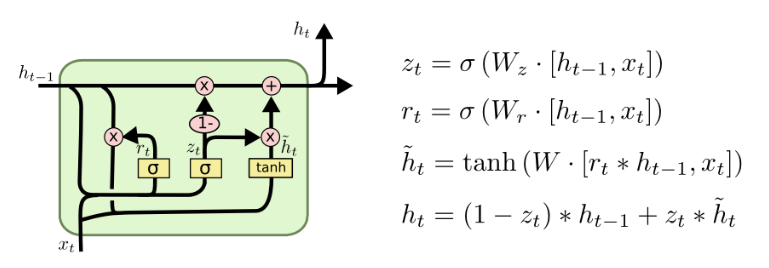

In [17]:
Image(filename = pth + "/images/gru.png")

**NOTE:** the $\tilde{h}_t$ represents the new gate, $n_t$

[Image source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)



### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*.

- **Bidirectional RNN:** there are two RNNs per layer:
- A *forward RNN* going over the sentence from left to right (shown below in green), and
- a *backward RNN* going over the sentence from right to left (yellow).

In PyTorch all we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before.

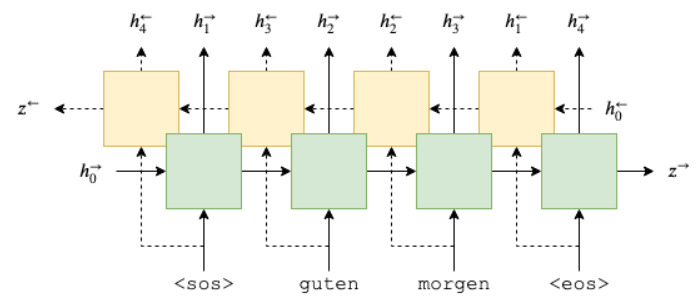

In [13]:
Image(filename= pth + "/images/3_encoderGRU_bidirectional.png")

We now have:

$$
h_t^\rightarrow = \text{EncoderGRU}^\rightarrow(x_t^\rightarrow,h_t^\rightarrow) 
$$
$$
h_t^\leftarrow = \text{EncoderGRU}^\leftarrow(x_t^\leftarrow,h_t^\leftarrow)
$$

where ... 
- $x_0^\rightarrow = \text{<sos>}$
- $x_1^\rightarrow = \text{guten}$ and
- $x_0^\leftarrow = \text{<eos>}$
- $x_1^\leftarrow = \text{morgen}$.



##### [Inputs of Encoder Bi-directional GRU Model:](https://hyp.is/pBfL1BBNEeqtNBe_R-qBnQ/pytorch.org/docs/stable/nn.html)
- `srcEmbedding` = tensor of shape (`seqLen`, `batchSize`, `inputSize`) that contains the features of the input sequence.
	- This tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros.
- $h_0$ = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the initial hidden state for each element in the batch.(Defaults to zero if we don't pass it, and we don't pass it)

##### [Outputs of Encoder Bi-directional GRU Model:](https://hyp.is/srJishBNEeq9gDO7DA-0WQ/pytorch.org/docs/stable/nn.html)

- `outputs` = tensor of shape (`srcSentenceLen`, `batchSize`, `numDirections` * `hiddenSize`) that contains the output features $h_t$ from the last layer of the GRU, for each time step $t$. 
	- The first `hiddenDim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hiddenDim` elements are hidden states from the top layer backward RNN. 
	- We can think of the third axis as being the forward and backward hidden states **concatenated** together other: $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ , ..., $h_T = [h_T^\rightarrow; h_1^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

- $h_n$ = `hidden` = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the hidden state for $T =$`seqLen`.
	- **`hidden[-2, :, :]`** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence). 
		- This is called the context vector from the forward RNN: $z^\rightarrow=h_T^\rightarrow$
	- **`hidden[-1, :, :]`** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).
		- This is called the context vector from the backward RNN: $z^\leftarrow=h_T^\leftarrow$


**NOTE: About Combining Context Vectors as Input for `Decoder`:**
As the `Decoder` is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$. 
But we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). 
We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function:

$$
z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0
$$

**WARNING**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so I've changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, inputDim: int, embedDim: int, 
                 encoderHiddenDim: int, decoderHiddenDim: int, 
                 dropout: float):

        super().__init__()

        # NOTE: no dropout since GRU has only 1 layer!
        self.embeddingLayer = nn.Embedding(num_embeddings=inputDim,
                                           embedding_dim=embedDim)

        # This is the linear layer function g() through which we pass the concatenated 
        # hidden states to get the context vector, z
        self.gLinearLayer = nn.Linear(in_features=encoderHiddenDim * 2,
                                      out_features = decoderHiddenDim)
        
        self.rnn = nn.GRU(input_size=embedDim, hidden_size=encoderHiddenDim,
                          bidirectional=True)

        # During training, randomly zeroes some of the elements of the input tensor 
        # with probability p using samples from a Bernoulli distribution. Each channel 
        # will be zeroed out independently on every forward call.
        # Good for regularization
        # SOURCE: https://hyp.is/qrKgZg0-EeqHWhNj0dgBjw/pytorch.org/docs/stable/nn.html
        self.dropout = nn.Dropout(dropout)


    def forward(self, src: Tensor) -> Tensor:
        """
        Passing the source sentence X (tensor) which has been converted into dense vectors
        using the embedding layer. 
        Then apply dropout. 
        Do recurrent calculation of hidden states over the whole sequence. 
        
        :param src: tensor X holding the input vectors x_1, ... x_T
        Has shape: (srcSentenceLen, batchSize)
        :return: 
            hidden: the final hidden state for each layer, h_T, stacked on top of each other
            This acts as the context vector `z` in the overall Seq2Seq model
        """
        # Convert the source sentence X to dense vectors using embedding layer
        srcEmbedding = self.dropout(self.embeddingLayer(src))
        # srcEmbedding shape: (srcSentenceLen, batchSize, embedDim)

        outputs, hidden = self.rnn(srcEmbedding) # no cell state returned since this RNN is GRU
        ## outputs shape: (srcSentenceLen, batchSize, encoderHiddenDim * numDirections)
        ## hidden shape: (numLayers * numDirections, batchSize, decoderHiddenDim)

        # NOTE: outputs are always from the top hidden layer
        
        ### NOTE: hidden is now stacked: [forward_1, backward_1, forward_2, backward_2, ...]
        ### ---> use hidden[-2, :, :] to get the last of the forwards RNN
        ### ---> use hidden[-1, :, :] to get the last of the backwards RNN
        
        # Initial decoder hidden state == final hidden state of forwards and backwards
        # 1. Concatenate the forwards and backwards
        # (this is creating the annotations: 
        # https://hyp.is/LsspQhCFEeqKPGtfX2Y_Xg/arxiv.org/pdf/1409.0473.pdf)
        fwdBackContextTensors: Tensor = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        # 2. push through linear layer, g()
        # 3. push through tanh()
        hidden = torch.tanh(self.gLinearLayer(fwdBackContextTensors))
        
        
        # since numDirections = 2 ... (since Encoder is bidirectional)
        ### outputs shape: (srcSentenceLen, batchSize, encoderHiddenDim * 2)
        ### hidden shape: (batchSize, decoderHiddenDim)
        return outputs, hidden  # context vector
    

### Attention

Next up is the attention layer. 

**Intuitive Definition of Attention Layer:** 
The attention layer takes in in the previous hidden state of the decoder, $s_{t-1}$ (what has been decoded so far by the `Decoder`) and also takes in all of the stacked forward and backward hidden states from the encoder, $H$ (all of what has been encoded so far by the `Encoder`). 
Then the attention layer uses these to produce an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1. The attention vector $a_t$ represents which words in the source sentence the `Decoder` should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

**Formula Definition of Attention Layer:**
First, calculate the *energy* $E_t$ between the previous decoder hidden state and the encoder hidden states. As encoder hidden states are a sequence of $T$ tensors, and previous decoder hidden state is a single tensor, the first thing to do is `repeat` the previous decoder hidden state $T$ times. Then calculate the energy, $E_t$, between them by concatenating them and passing the result through a linear layer (`attentionLinearLayer`) and a $\tanh$ activation function:
$$
E_t = \tanh(\text{attentionLinearLayer}(s_{t-1}, H))
$$ 
where $H = \{h_1, h_2, ..., h_T\}$

Intuitively, the energy calculates how well each `Encoder` hidden state "matches" the previous `Decoder` hidden state.

Formulaically, the paper says that the energy $e_{ij} = a(s_{t-1}, h_j)$ is an [alignment model](https://hyp.is/hTdBLBCEEeqNeLtcPGf5lQ/arxiv.org/pdf/1409.0473.pdf) which scores how well the inputs around position $j$ and the output at position $i$ match. This score is based on the RNN hidden state $s_{i-1}$ (just before emitting $y_t$) and the $j$-th annotation $h_j$ of the input sequence. 

**KEY FEATURES:** [The purpose of the alignment is to:](https://hyp.is/koZYmhCEEeqz0ytUsVvYvg/arxiv.org/pdf/1409.0473.pdf)
- compute a "soft alignment" which allows the gradient of the cost function to be backpropagated through. This gradient can be used to train the *alignment model* $e_{tj}$ as well as the whole translation model **jointly**. 
- later compute the probability $\alpha_{tj}$ to implement an attention mechanism in the `Decoder`, so that the `Encoder` is relieved of the burden of having to encode all information in the source sentence into a fixed-length vector. 


We currently have a **`(decoderHiddenDim`, `srcSentenceLen`)** tensor for each example in the batch. We want this to be **(`srcSentenceLen`)** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **(1, `decoderHiddenDim`)** tensor, called $v$:

$$\hat{a}_t = v E_t$$
where $E_t$ represents $e_{tj}$.
This calculates a weighted sum of the "match" over all `decoderHiddenDim` elements for each encoder hidden state, where the weights are learned (while learning the parameters of $v$).

Finally, to ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1, it gets passed through a $\text{softmax}$ layer.

$$
a_t = \text{softmax}(\hat{a_t})
$$

This gives the attention over the source sentence.

- **NOTE:** This is an adapted version of the energy $e_{tj}$ in the paper since in the paper, the energy is pushed directly through the softmax function, but here, we must first multiply by the $v$ vector to get correct dimensions. 
In the paper, the result of energy going through the softmax is the weight $\alpha_{tj}$ of each annotation $h_j$: 
$$
\alpha_{tj} = \frac{e^{e_{tj}}} {\sum_{k = 1}^{T_x} e^{e_{tj}}}
$$

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

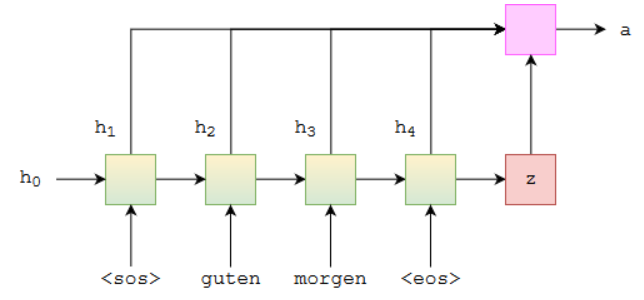

In [16]:
Image(filename = pth + "/images/3_attention.png")

In [31]:
class Attention(nn.Module):
    
    def __init__(self, encoderHiddenDim: int, decoderHiddenDim: int):
        
        super().__init__()
        
        self.attentionLinearLayer = nn.Linear(in_features = encoderHiddenDim * 2 + decoderHiddenDim,
                                              out_features=decoderHiddenDim)
        
        # Creating this vector of random numbers just for properly shaping the
        # energy tensor (aesthetic purpose only, for v)
        self.v = nn.Parameter(torch.rand(decoderHiddenDim))
        
    
    def forward(self, hidden: Tensor, encoderOutputs: Tensor) -> Tensor:
        """
        
        :param hidden:  
            shape = (batchSize, decoderHiddenDim) 
        :param encoderOutputs: 
            shape = (srcSentenceLen, batchSize, encoderHiddenDim * 2)
        :return: 
        """
        srcSentenceLen, batchSize = encoderOutputs.shape 
        
        # repeat encoder hidden state srcSentenceLen times
        hidden: Tensor = hidden.unsqueeze(1).repeat(1, srcSentenceLen, 1)
        ## hidden shape = (batchSize, srcSentenceLen, decoderHiddenDim)
        
        encoderOutputs: Tensor = encoderOutputs.permute(1, 0, 2)
        ## encoderOutputs shape = (batchSize, srcSentenceLen, encoderHiddenDim * 2)
        
        energy: Tensor = torch.tanh(self.attentionLinearLayer(
            torch.cat((hidden, encoderOutputs), dim = 2)))
        ## energy shape = (batchSize, srcSentenceLen, decoderHiddenDim)
        
        energy: Tensor = energy.permute(0, 2, 1)
        ## energy shape now = (batchSize, decoderHiddenDim, srcSentenceLen)
        
        # V shape = (decoderHiddenDim)
        # NOTE: v has aesthetic purpose only, to properly shape the attention vector.
        v = self.v.repeat(batchSize, 1).unsqueeze(1)
        ## v shape now = (batchSize, 1, decoderHiddenDim)
        
        # Multiplying v * E_t then removing the dimension 1 to get attention vector
        # of shape (srcSentenceLen)
        attention = torch.bmm(v, energy).squeeze(1) 
        ## attention shape = (batchSize, srcLen)
        # TODO: srcLen == srcSentenceLen ????
        # TODO: why is this not the expected shape? (vector)?
        
        return F.softmax(input = attention, dim = 1)
        

### Decoder

Next up is the decoder.

##### Attention  Mechanism via Context Vector: 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$
where $H = \{h_1, ..., h_T\}$ is a tensor containing the hidden states. 

[**Formula Definition of Context Vector:**](https://hyp.is/a4cHvBCEEeqsJlM_ngKoPQ/arxiv.org/pdf/1409.0473.pdf)
The paper calls this weighted sum the context vector:
$$
c_t = \sum_{j=1}^{T_x} \alpha_{tj} h_j
$$ 
The context vector $c_t$ depends on a sequence of annotations (hidden states) $\{h_1, ..., h_{T_x} \}$ to which the `Encoder` maps the input sequence. Each annotation (hidden state) $h_t$ contains information about the whole sentence input sequence with a strong focus on parts surrounding the $i$-th word of the input sequence. 

[**Intuitive Definition of Context Vector:**](https://hyp.is/oJpz5BCEEeqfRyMXGk5sCg/arxiv.org/pdf/1409.0473.pdf)
Intuitively, the context vector can be interpreted as follows: taking a weighted sum of all the annotations (hidden states) $h_j$ means computing an *expected annotation*, where the expectation is over all possible alignments. We have $\alpha_{tj}$ is the probability that the target word $y_t$ is aligned to or translated from a source word $x_j$. Then the $t$-th context vector at time $t$ is $c_t$ is the expected annotation over all the annotations $h_j$ with probabilities $\alpha_{tj}$
The probability $\alpha_{tj}$ or its associated energy $e_{tj}$ reflects the importance of the annotation $h_j$ with respect to the previous hidden state $s_{t-1}$ of the `Decoder` in deciding the next state $s_i$ and generating the target $y_t$. 
This acts as an attention mechanism in the `Decoder`. 
The `Decoder` decides which parts of the source sentence it must pay attention to. 
[**Key purpose:**](https://hyp.is/4h2kThCEEeqXUfPFPlUP2w/arxiv.org/pdf/1409.0473.pdf) By letting the `Decoder` have attention mechanism, we relieve the `Encoder` from the burden of having to encode all information in the source sentence into a fixed-length vector. This way, information can be spread throughout the sequence of annotations which can then be selectively retrieved by the `Decoder`.  



##### [DecoderRNN  Formula:](https://hyp.is/ODSeYBCEEeqsqje0gfKtaA/arxiv.org/pdf/1409.0473.pdf)

The input word (that has been embedded), $y_t$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(y_t, w_t, s_{t-1}) $$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the first word in an example translation.
The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

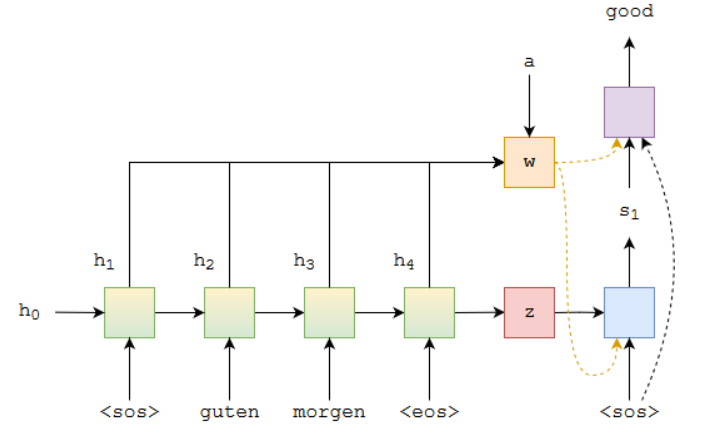

In [33]:
Image(filename = pth + "/images/3_decoderGRU.png")


The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, outputDim: int, embedDim: int, 
                 encoderHiddenDim: int, decoderHiddenDim: int, dropout: float, 
                 attention: Attention):